##Read in data for the first time

##Bring in libraries and credentials

In [2]:
import datetime
import pandas as pd
import numpy as np
import plotly
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
import time 
Tokens = tls.get_credentials_file()['stream_ids']
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
AllData=pd.read_csv('K:\Rainshelter\Fodderbeet 2016-2017\LoggedData\RainShelterAlpha_CS650.dat', #specify file path for data to read in
                         parse_dates=True, #tell the function to parse date columns to datetime formats
                         dayfirst=True, #tell the function that the day is before the year in the data i.e format='%d/%m/%Y %H:%M'
                         skiprows = [0,2,3], #leave out rows 1, 3 and 4 which have redundant information
                         index_col = 0, #Use the first column, which is Date, as an index
                         na_values = 'NAN')

##Apply indexing for the first time

In [4]:
#Bring in index data
AllDataIndex=pd.read_csv('K:\Rainshelter\Fodderbeet 2016-2017\LoggedData\SoilWaterAndTempIndex.csv',
                         index_col = 0)
#Apply indexes to data
AllDataTransposed = AllData.transpose()
AllDataIndexed = pd.concat([AllDataIndex,AllDataTransposed], axis=1)
AllDataIndexed.index.name='ColumnHeader'
AllDataIndexed.set_index(['Measurement','Depth','Nitrogen','Irrigation','Plot','Sensor', 'MUX', 'Port','Units','Summary','Block','Treatment'], 
                        append=False, inplace=True)
AllDataIndexed.sort_index(inplace=True)
FieldData=AllDataIndexed.transpose()
FieldData.index = FieldData.index.to_datetime()  ## for some reason the concat function changes the data type on the date indes so need to change it back

#Record the last row number read in
LastRow = FieldData.index.size
np.save('LastRow.npy',LastRow)
FieldData.to_pickle('.\FieldData.pkl')

In [5]:
%matplotlib inline
#FieldData = UpdataDataFrame()
#Calculate treatment means omitting data prior to 2014-11-05 08:00:00 to avoid NaN values
DataMeans =  FieldData.ix['2016-11-16':].groupby(level=['Measurement','Depth','Irrigation', 'Nitrogen'],axis=1).mean()
DataMeans =  DataMeans.dropna(axis=1) #For some reason it keeps non valid combinations in so need to extract with this function
DataMeans = DataMeans.resample('4H').last()

#Calculate the water content of the soil profile by multiplying the volumetric water content by each layers
#depth and summing.  The 0-15 layers are divided by 2 to average the two readings
ProfileWater = DataMeans.VolumetricWaterContent.where(DataMeans.VolumetricWaterContent<1).ix[:,'D1I'] * 150/2 + \
               DataMeans.VolumetricWaterContent.where(DataMeans.VolumetricWaterContent<1).ix[:,'D1B'] * 150/2 + \
               DataMeans.VolumetricWaterContent.where(DataMeans.VolumetricWaterContent<1).ix[:,'D2'] * 150 + \
               DataMeans.VolumetricWaterContent.where(DataMeans.VolumetricWaterContent<1).ix[:,'D3'] * 300 + \
               DataMeans.VolumetricWaterContent.where(DataMeans.VolumetricWaterContent<1).ix[:,'D4'] * 300 + \
               DataMeans.VolumetricWaterContent.where(DataMeans.VolumetricWaterContent<1).ix[:,'D5'] * 300 + \
               DataMeans.VolumetricWaterContent.where(DataMeans.VolumetricWaterContent<1).ix[:,'D6'] * 300 + \
               DataMeans.VolumetricWaterContent.where(DataMeans.VolumetricWaterContent<1).ix[:,'D7'] * 300

FieldCapacity = ProfileWater.resample('D').max()
FieldCapacity = FieldCapacity.ix['2016-11-16'] +30 # I would have though this would return a data frame with a single row but instead it returns a series with a multiindex in columns
SoilWaterDeficit = -(FieldCapacity - ProfileWater)

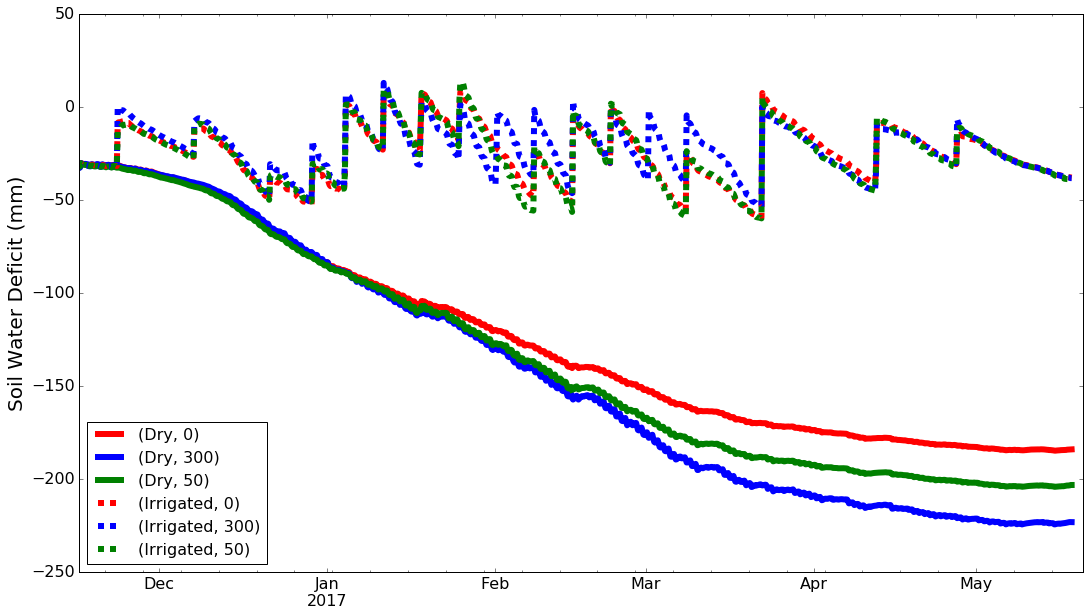

In [13]:
SoilWaterDeficit.ix[:'2017-05-20'].plot(figsize=(18,10),linewidth=6,style=['r-','b-','g-','r--','b--','g--'])
plt.tick_params(labelsize=16)
plt.ylabel('Soil Water Deficit (mm)',fontsize=20)
plt.legend(loc=3,fontsize=16)

In [6]:
GraphData = DataMeans.VolumetricWaterContent
for irr in ['Dry','Irrigated']:
    for N in ['0','50','300']:
        GraphData.loc[:,('D1',irr,N)] = (GraphData.loc[:,('D1B',irr,N)]+GraphData.loc[:,('D1I',irr,N)])/2
GraphData.drop(['D1B','D1I'],axis=1,inplace=True)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:284: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:545: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\cflhxb\AppData\Roaming\Python\Python27\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



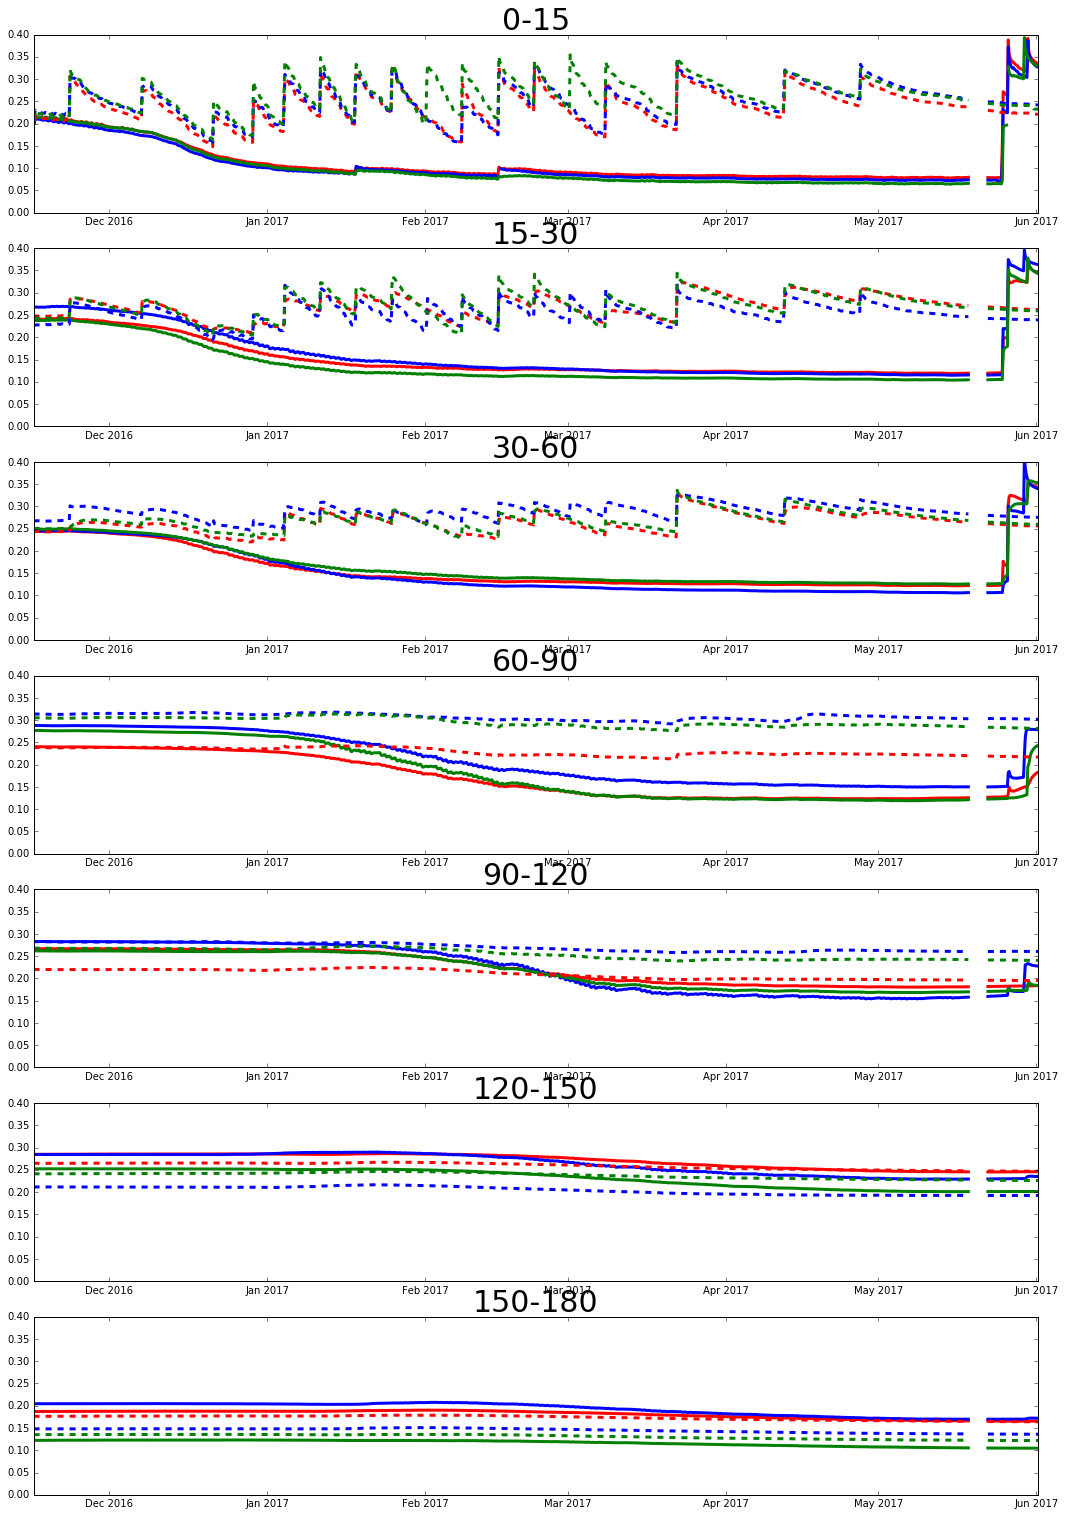

In [7]:
Depths = ['D1','D2','D3','D4','D5','D6','D7']
labels = ['0-15','15-30','30-60','60-90','90-120','120-150','150-180']
from cycler import cycler
graph = plt.figure(figsize=(18,30))

pos=1
for Depth in Depths:
    ax = graph.add_subplot(8,1,pos)
    ax.set_prop_cycle(cycler('color',['r','b','g','r','b','g']) +
                     cycler('linestyle',['-','-','-','--','--','--']))
    DepthData = GraphData.where(GraphData<1).ix[:,Depth]
    plt.plot(DepthData,linewidth = 3)
    plt.title(labels[pos-1],fontsize=30)
    plt.ylim(0,0.4)
    pos+=1

##Function to read in fresh data and update status files

In [7]:
#Bring in date recorded since last update
def UpdataDataFrame():
    #Bring in previous status files
    LastRead = np.load('.\LastRow.npy')
    FieldData = pd.read_pickle('.\FieldData.pkl')
    #Bring in index data
    AllDataIndex=pd.read_csv('K:\Rainshelter\Fodderbeet 2016-2017\LoggedData\SoilWaterAndTempIndex.csv',
                         index_col = 0)
    
    #Bring in fresh data
    StartRead = LastRead + 4
    Skips = [0,2,3] + list(range(4,StartRead))
    FreshData=pd.read_csv('K:\Rainshelter\Fodderbeet 2016-2017\LoggedData\RainShelterAlpha_CS650.dat', #specify file path for data to read in
                             parse_dates=True, #tell the function to parse date columns to datetime formats
                             dayfirst=True, #tell the function that the day is before the year in the data i.e format='%d/%m/%Y %H:%M'
                             skiprows = Skips, #rows that have already be read
                             index_col = 0, #Use the first column, which is Date, as an index
                             na_values = 'NAN')

    #Apply indexes to fresh data
    FreshDataTransposed = FreshData.transpose()
    FreshDataIndexed = pd.concat([AllDataIndex,FreshDataTransposed], axis=1)
    FreshDataIndexed.index.name='ColumnHeader'
    FreshDataIndexed.set_index(['Measurement','Depth','Nitrogen','Irrigation','Plot','Sensor', 'MUX', 'Port','Units','Summary','Block','Treatment'], 
                            append=False, inplace=True)
    FreshDataIndexed.sort_index(inplace=True)
    NewData=FreshDataIndexed.transpose()
    
    #Join fresh data onto existing data
    FieldData = pd.concat([FieldData,NewData])
    FieldData.sort_index(inplace = True)
    
    #Update status files
    LastRow = FieldData.index.size
    np.save('LastRow.npy',LastRow)
    FieldData.to_pickle('.\FieldData.pkl')
    return FieldData

##Create object for each treament

In [8]:
#Treatment class constructor
class Treatment(object):
    def __init__(self, Number, Irrigation, Nitrogen):
        self.Number=Number
        self.Irrigation=Irrigation
        self.Nitrogen=Nitrogen
        self.streamID=Tokens[number]
        self.Label= Irrigation + ' ' + Nitrogen + 'N'
        self.Trace = Scatter(x=[],y=[], name = self.Label,
                stream = Stream(token=self.streamID)
                )
        self.Stream = py.Stream(self.streamID)

#Creat class with treatment data
Treatments = []
Colors = ['red','blue','green']
NRates = ['0','50','300']
IRates = ['Dry','Irrigated']
Lines = ['solid','dash']
number = 0
LinePos = 0
for I in IRates:
    ColorPos = 0
    for N in NRates:
        Treatments.append(Treatment(number, I, N))
        Treatments[number].Trace.line = Line(color = Colors[ColorPos], dash = Lines[LinePos])
        ColorPos +=1
        number += 1
    LinePos+=1
    

##Build base Plotly Graph

In [9]:
GraphData = Data([Treatments[0].Trace,
                  Treatments[1].Trace,
                  Treatments[2].Trace,
                  Treatments[3].Trace,
                  Treatments[4].Trace,
                  Treatments[5].Trace
                 ])

layout = Layout(title='FodderBeet Soil Water Deficits',
                xaxis=XAxis(title='Date'),
                yaxis=YAxis(title='Soil Water Deficit (mm)'))

Fig = Figure(data=GraphData, layout=layout)

unique_url = py.plot(Fig, filename = 'RainShelterFodderBeet', fileopt = 'extend', sharing = 'secret')

PlotlyError: Aw, snap! You tried to use our API as the user 'HamishBrown', but the supplied API key doesn't match our records. You can view your API key at plot.ly/settings.

You're most likely getting this message because your local credentials file isn't synced with the Plotly server you're communicating with.

Go to plot.ly/<language>/getting-started (e.g., plot.ly/python/getting-started) for more information.

Make sure that you're logged in as HamishBrown.

Need help? Please try searching Plotly's <a href='http://stackoverflow.com/questions/tagged/plotly'>Stack Overflow channel</a>.

In [ ]:
for T in Treatments:
    print(T.streamID)

##Function to Updata data frame and traces and stream to Plotly

In [ ]:
def Update():
    #Update Data Frame with data that has been logged since last update
    FieldData = UpdataDataFrame()
    #Calculate treatment means omitting data prior to 2014-11-05 08:00:00 to avoid NaN values
    DataMeans =  FieldData.ix['2016-11-16':].groupby(level=['Measurement','Depth','Irrigation', 'Nitrogen'],axis=1).mean()
    DataMeans =  DataMeans.dropna(axis=1) #For some reason it keeps non valid combinations in so need to extract with this function
    DataMeans = DataMeans.resample('4H').last()
    
    #Calculate the water content of the soil profile by multiplying the volumetric water content by each layers
    #depth and summing.  The 0-15 layers are divided by 2 to average the two readings
    ProfileWater = DataMeans.VolumetricWaterContent.ix[:,'D1I'] * 150/2 + \
                   DataMeans.VolumetricWaterContent.ix[:,'D1B'] * 150/2 + \
                   DataMeans.VolumetricWaterContent.ix[:,'D2'] * 150 + \
                   DataMeans.VolumetricWaterContent.ix[:,'D3'] * 300 + \
                   DataMeans.VolumetricWaterContent.ix[:,'D4'] * 300 + \
                   DataMeans.VolumetricWaterContent.ix[:,'D5'] * 300 + \
                   DataMeans.VolumetricWaterContent.ix[:,'D6'] * 300 + \
                   DataMeans.VolumetricWaterContent.ix[:,'D7'] * 300

    FieldCapacity = ProfileWater.resample('D').max()
    FieldCapacity = FieldCapacity.ix['2016-11-16'] +30 # I would have though this would return a data frame with a single row but instead it returns a series with a multiindex in columns
    SoilWaterDeficit = -(FieldCapacity - ProfileWater)    # This calculation only works because field capacity is a multi index series

    X = SoilWaterDeficit.index
    for Treatment in Treatments:
        Treatment.Stream.open()
        Treatment.Stream.write({'x':X,'y':SoilWaterDeficit.ix[:,(Treatment.Irrigation,Treatment.Nitrogen)]})
        Treatment.Stream.close()

In [ ]:
#Testing stuff

#Update Data Frame with data that has been logged since last update
FieldData = UpdataDataFrame()
#Calculate treatment means omitting data prior to 2014-11-05 08:00:00 to avoid NaN values
DataMeans =  FieldData.ix['2016-11-16':].groupby(level=['Measurement','Depth','Irrigation', 'Nitrogen'],axis=1).mean()
DataMeans =  DataMeans.dropna(axis=1) #For some reason it keeps non valid combinations in so need to extract with this function
DataMeans = DataMeans.resample('4H').last()

#Calculate the water content of the soil profile by multiplying the volumetric water content by each layers
#depth and summing.  The 0-15 layers are divided by 2 to average the two readings
ProfileWater = DataMeans.VolumetricWaterContent.ix[:,'D1I'] * 150/2 + \
               DataMeans.VolumetricWaterContent.ix[:,'D1B'] * 150/2 + \
               DataMeans.VolumetricWaterContent.ix[:,'D2'] * 150 + \
               DataMeans.VolumetricWaterContent.ix[:,'D3'] * 300 + \
               DataMeans.VolumetricWaterContent.ix[:,'D4'] * 300 + \
               DataMeans.VolumetricWaterContent.ix[:,'D5'] * 300 + \
               DataMeans.VolumetricWaterContent.ix[:,'D6'] * 300 + \
               DataMeans.VolumetricWaterContent.ix[:,'D7'] * 300

FieldCapacity = ProfileWater.resample('D').max()
FieldCapacity = FieldCapacity.ix['2016-11-16'] +30 # I would have though this would return a data frame with a single row but instead it returns a series with a multiindex in columns
SoilWaterDeficit = -(FieldCapacity - ProfileWater)    # This calculation only works because field capacity is a multi index series

X = SoilWaterDeficit.index
Treatments[0].Stream.open()
Treatments[0].Stream.write({'x':X,'y':SoilWaterDeficit.ix[:,(Treatments[0].Irrigation,Treatments[0].Nitrogen)].values})

In [ ]:
X

In [ ]:
SoilWaterDeficit.ix[0:200,(Treatments[0].Irrigation,Treatments[0].Nitrogen)].values

##Continious update

In [ ]:
while True:
    if time.localtime()[3] == 6:
        try:
            Update() #get fresh data and send to graph
        except:
            retrys = 1
            print('Attempt to stream data failed')
            while retrys < 10: ##retry connecting 10 times
                time.sleep(300)  ##wait 5 min 
                try:
                    Update() # have another go
                except:
                    print('Retry' + str(retrys) + ' failed')
                    retrys +=1 #increment try counter and try again
                else:
                    retrys = 12 #set try counter so loop is exited
    time.sleep(3600)  ## try again in an hours time

##One off update

In [ ]:
Update()

Trying to get this to work

In [ ]:
#Update Data Frame with data that has been logged since last update
FieldData = UpdataDataFrame()
#Calculate treatment means omitting data prior to 2014-11-05 08:00:00 to avoid NaN values
DataMeans =  FieldData.ix['2016-11-16':].groupby(level=['Measurement','Depth','Irrigation', 'Nitrogen'],axis=1).mean()
DataMeans =  DataMeans.dropna(axis=1) #For some reason it keeps non valid combinations in so need to extract with this function
DataMeans = DataMeans.resample('4H').last()

#Calculate the water content of the soil profile by multiplying the volumetric water content by each layers
#depth and summing.  The 0-15 layers are divided by 2 to average the two readings
ProfileWater = DataMeans.VolumetricWaterContent.ix[:,'D1I'] * 150/2 + \
               DataMeans.VolumetricWaterContent.ix[:,'D1B'] * 150/2 + \
               DataMeans.VolumetricWaterContent.ix[:,'D2'] * 150 + \
               DataMeans.VolumetricWaterContent.ix[:,'D3'] * 300 + \
               DataMeans.VolumetricWaterContent.ix[:,'D4'] * 300 + \
               DataMeans.VolumetricWaterContent.ix[:,'D5'] * 300 + \
               DataMeans.VolumetricWaterContent.ix[:,'D6'] * 300 + \
               DataMeans.VolumetricWaterContent.ix[:,'D7'] * 300

FieldCapacity = ProfileWater.resample('D').max()
FieldCapacity = FieldCapacity.ix['2016-11-16'] +30 # I would have though this would return a data frame with a single row but instead it returns a series with a multiindex in columns
SoilWaterDeficit = -(FieldCapacity - ProfileWater)    # This calculation only works because field capacity is a multi index series

X = SoilWaterDeficit.index
#     for Treatment in Treatments:
#         Treatment.Stream.open()
#         Treatment.Stream.write({'x':X,'y':SoilWaterDeficit.ix[:,(Treatment.Irrigation,Treatment.Nitrogen)]})
#         Treatment.Stream.close()

In [ ]:
Treatments[0].Stream.open()

In [ ]:
Treatments[0].Stream.write({'x':X,'y':SoilWaterDeficit.ix[:,(Treatments[0].Irrigation,Treatments[0].Nitrogen)]})